In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf

### Get Data

In [77]:
ETFs = {
    "XWD.TO":"MSCI_World (Index)",
    "IWDA.AS":"iShares Core MSCI World UCITS ETF USD (Acc)"
}

data = {}

for item in ETFs:

    data[item] = yf.download(item, start="1970-1-2")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Compare prices

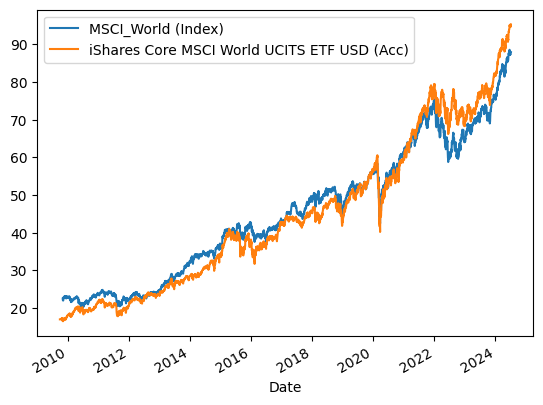

In [78]:
fig, ax = plt.subplots()

for item in data:
    data[item]["Close"].plot(ax=ax, label=ETFs[item])

ax.legend()
plt.show()

### Analyze

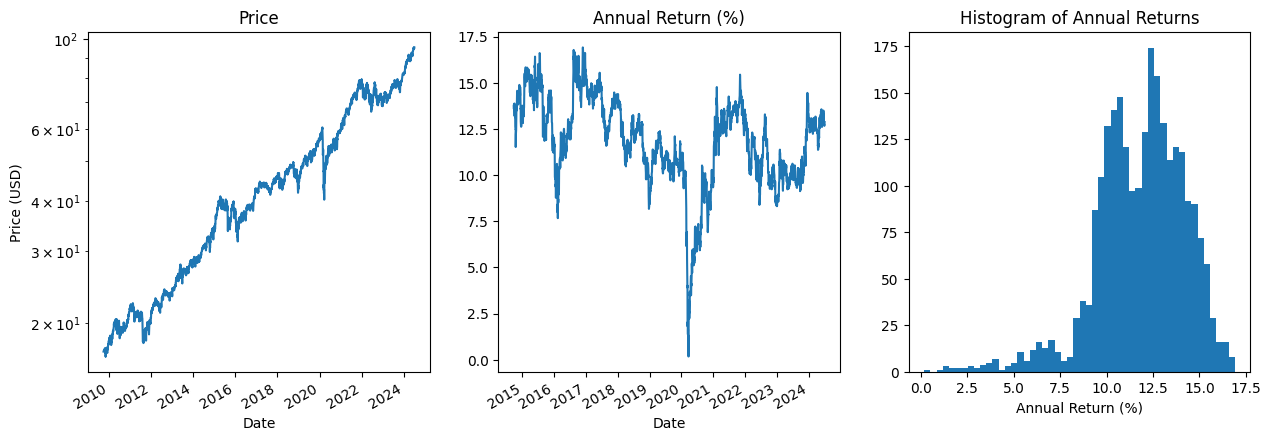

In [111]:
etf_data = data["IWDA.AS"]

years_holding_list = [5]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title("Price")
ax[1].set_title("Annual Return (%)")
ax[2].set_title("Histogram of Annual Returns")

for years_holding in years_holding_list:

    df = etf_data["Adj Close"].to_frame().rename(columns = {'Adj Close':"Price"})

    num_days = (df.index[-1]-df.index[0]).days
    num_recorded_days = len(df)
    recorded_days_per_year = 365*(num_recorded_days / num_days)
    recorded_days_holding = int(recorded_days_per_year*years_holding)
    
    shifted_price = df['Price'].shift(recorded_days_holding) # shifts the prices forward, putting NaN before
    
    df['return'] = (df['Price'] - shifted_price)/shifted_price # total return after years_holding
    df['return'] = (df['return'] + 1) ** (1/years_holding) - 1 # annualized return
    df['return'] = df['return']*100 # percentage

    df['Price'].plot(ax=ax[0])
    #shifted_price.plot(ax=ax[0])

    df['return'].plot(ax=ax[1])
    df['return'].hist(ax=ax[2], bins=50)

ax[0].set_yscale("log")
ax[0].set_ylabel("Price (USD)") 

ax[2].set_xlabel("Annual Return (%)")
ax[2].grid(False)

plt.show()

In [117]:
# Strategy: 
# sell if the current return is above R%
# buy if the value drops below of L% with respect to the last sell
# OR buy if more than Z days have passed since the last sell

# Parameters:
R = 0.8 # %
L = -0.02 # %
Z = 5

ETF = "IWDA.AS"
years_holding = 5

etf_data = data[ETF]
df = etf_data["Adj Close"].to_frame().rename(columns = {'Adj Close':"Price"})

num_days = (df.index[-1]-df.index[0]).days
num_recorded_days = len(df)
recorded_days_per_year = 365*(num_recorded_days / num_days)
recorded_days_holding = int(recorded_days_per_year*years_holding)

num_periods = len(df) - recorded_days_holding
results = []

for i in tqdm(range(num_periods)):

    period = df.index[i:i+recorded_days_holding]
    initial_buy_day = period[0]

    initial_investment_value = 100
    final_investment_value = initial_investment_value

    buy_days = [initial_buy_day,]
    buy_prices = [df['Price'].loc[initial_buy_day],]
    sell_days = []
    sell_prices = []

    last_buy_price = df['Price'].loc[initial_buy_day]
    last_sell_price = 0.
    holding = True

    for day in period[1:]:

        current_price = df['Price'].loc[day]
        
        if holding:
            current_return = (current_price - last_buy_price)/last_buy_price

            if current_return > R:
                sell_days.append(day)
                sell_prices.append(current_price)
                final_investment_value += final_investment_value*current_return
                last_sell_price = current_price
                holding = False

        else:
            current_variation = (current_price - last_sell_price)/last_sell_price

            if current_variation < L or (day - sell_days[-1]).days > Z:
                buy_days.append(day)
                buy_prices.append(current_price)

                last_buy_price = current_price
                holding = True
            

    total_return = (final_investment_value - initial_investment_value)/initial_investment_value
    yearly_return = (1 + total_return)**(1/years_holding) - 1
    yearly_return = yearly_return*100

    total_return_no_strategy = (df['Price'].loc[period[-1]] - df['Price'].loc[period[0]])/df['Price'].loc[period[0]]
    yearly_return_no_strategy = (1 + total_return_no_strategy)**(1/years_holding) - 1
    yearly_return_no_strategy = yearly_return_no_strategy*100

    results.append(
        {
            "initial_buy_day":initial_buy_day,
            "yearly_return":yearly_return,
            "yearly_return_no_strategy":yearly_return_no_strategy,
            "sell_days":sell_days,
            "sell_prices":sell_prices,
            "buy_days":buy_days,
            "buy_prices":buy_prices
        }
    )

100%|██████████| 2504/2504 [00:28<00:00, 88.01it/s]


0.0 7.868722393921544 12.496947816637515 12.880836781870975
0.3113833367127228 11.810246660351595 12.099892245765687 16.937508546484036


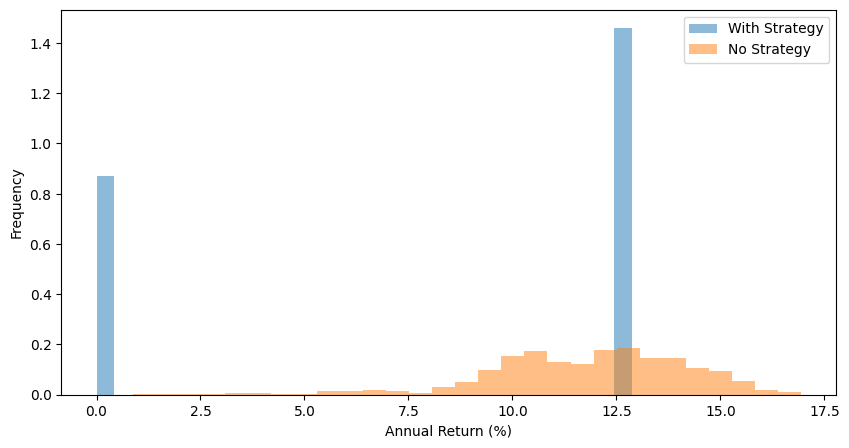

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))

returns = [result["yearly_return"] for result in results]
returns_no_strategy = [result["yearly_return_no_strategy"] for result in results]

print(min(returns), np.mean(returns), np.median(returns), max(returns))
print(min(returns_no_strategy), np.mean(returns_no_strategy), np.median(returns_no_strategy), max(returns_no_strategy))

ax.hist(returns, bins=30, alpha=0.5, label="With Strategy", density=True)
ax.hist(returns_no_strategy, bins=30, alpha=0.5, label="No Strategy", density=True)

ax.set_xlabel("Annual Return (%)")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()